In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3070


In [3]:
# Load the dataset
file_path = 'Training_Essay_Data.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(dataset.head())
# Check the dataset information
print(dataset['generated'].value_counts())
dataset.info()

                                                text  generated
0  Car-free cities have become a subject of incre...          1
1  Car Free Cities  Car-free cities, a concept ga...          1
2    A Sustainable Urban Future  Car-free cities ...          1
3    Pioneering Sustainable Urban Living  In an e...          1
4    The Path to Sustainable Urban Living  In an ...          1
generated
0    17508
1    11637
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29145 entries, 0 to 29144
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       29145 non-null  object
 1   generated  29145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 455.5+ KB


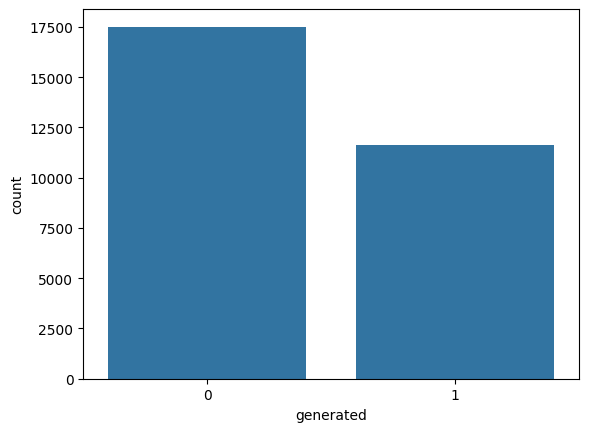

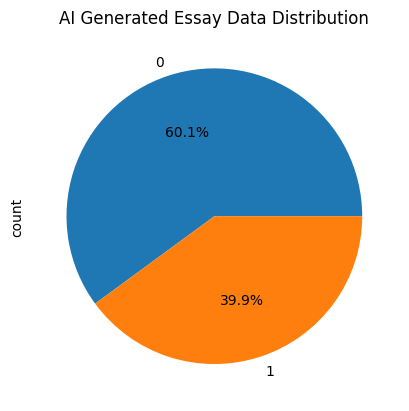

In [4]:
sns.countplot(x=dataset['generated'])
plt.show()

dataset['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("AI Generated Essay Data Distribution")
plt.show()

In [5]:
# Balancing the dataset by oversampling the minority class
def balance_labels(df, label_column='generated'):
    # Get the counts of each label
    label_counts=df[label_column].value_counts()
    # Get the maximum count
    max_count=label_counts.max()
    # Create an empty DataFrame
    balanced_df=pd.DataFrame()

    # For each label, create a subset of the DataFrame with that label
    for label, count in label_counts.items():
        # If the count is equal to the maximum count, don't do anything
        label_subset = df[df[label_column]==label]
        # Create a subset of the label with replacement
        oversampled_subset= label_subset.sample(n=(max_count-count), replace=True, random_state=42)
        balanced_df = pd.concat([balanced_df, label_subset, oversampled_subset], ignore_index=True)

    return balanced_df

dataset = balance_labels(dataset)

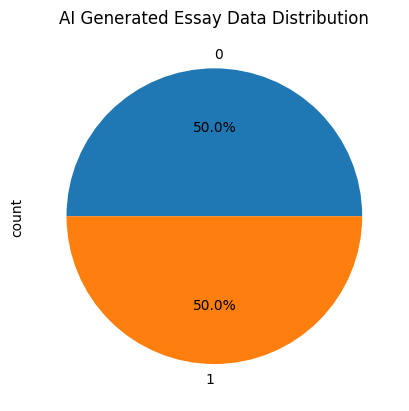

generated
0    17508
1    17508
Name: count, dtype: int64

In [6]:
dataset['generated'].value_counts().plot(kind="pie",autopct="%.1f%%")
plt.title("AI Generated Essay Data Distribution")
plt.show()
# Check the dataset statistics
dataset['generated'].value_counts()

In [7]:
# Check for missing values
print(dataset.isnull().sum())

# Drop rows with missing values (if any)
dataset.dropna(inplace=True)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset['text'], dataset['generated'], test_size=0.2, random_state=42)


text         0
generated    0
dtype: int64


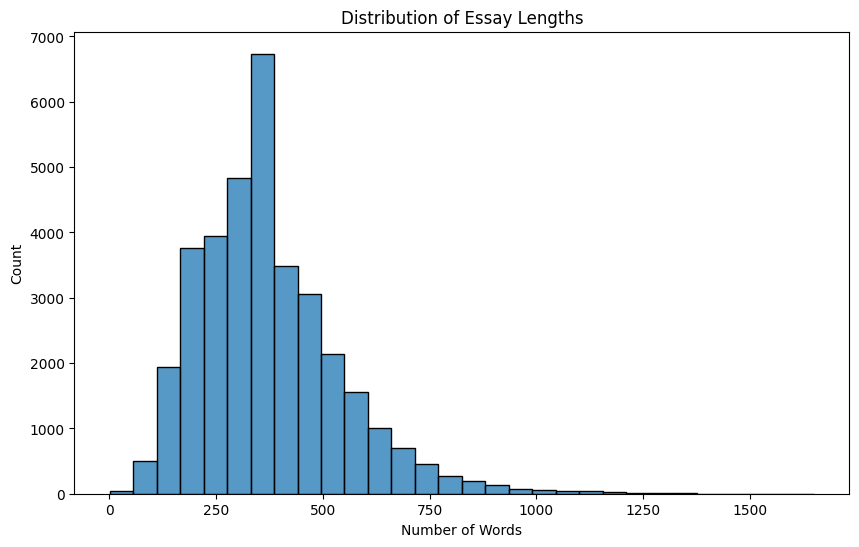

Ave Length:  371 words
Min Length:  1 words
Max Length:  1650 words


In [8]:
# Ploy the distribution of the essay lengths
plt.figure(figsize=(10, 6))
sns.histplot(dataset['text'].apply(lambda x: len(x.split())), bins=30)
plt.title('Distribution of Essay Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

# Get average length of the essays
avg_length = dataset['text'].apply(lambda x: len(x.split())).mean()
# Get the min and max length of the essays
min_length = dataset['text'].apply(lambda x: len(x.split())).min()
max_length = dataset['text'].apply(lambda x: len(x.split())).max()
print("Ave Length: ", round(avg_length), "words")
print("Min Length: ", min_length, "words")
print("Max Length: ", max_length, "words")

### TF-IDF with ngram_range setting and regularization & penalty intensity tuning

In [55]:
from sklearn.metrics import f1_score

# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=0.01)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#use L2 regularizaiton with sage solver(since better for reducing overfitting and also better for preventing sparsity matrix)
#and since the dataset is already oversampled, we do not need to apply class_weight="balanced") in logisticRegression
lr_model = LogisticRegression(
    penalty='l2', random_state=50, solver="saga"
)
lr_model.fit(X_train_tfidf, y_train)

y_pred = lr_model.predict(X_test_tfidf)
f1_micro = f1_score(y_test, y_pred, average="micro")
###f1_macro = f1_score(y_test, y_pred, average="macro")

#print out f1 results
print('f1 score for micro-averaging is:', f1_micro)
###print('f1 score for macro-averaging is:', f1_macro)

f1 score for micro-averaging is: 0.9985929648241206


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [56]:
###pip install optuna
import optuna

#fine tune the reverse of regulartization(intensity) with optuna optimization
dist = {
    "C": optuna.distributions.FloatDistribution(1e-8, 100.0, log=True),
}

#we have to maximize the C value for the optimal penality intensity
study = optuna.create_study(direction="maximize")
trials = 15

for _ in range(trials):
    trial = study.ask(dist)
    C = trial.params["C"]
    clf = LogisticRegression(C=C, solver="saga", max_iter=1000)
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)
    f1 = f1_score(y_test, y_pred, average="micro")

    study.tell(trial, f1)

study.best_params, study.best_value

[I 2024-07-30 16:38:27,441] A new study created in memory with name: no-name-cec4060b-b595-40b1-9dca-9d88856fb0f7


({'C': 15.560335117665725}, 1.0)

In [59]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=0.01)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#use L2 regularizaiton with sage solver(since better for reducing overfitting and also better for preventing sparsity matrix)
#and since the dataset is already oversampled, we do not need to apply class_weight="balanced") in logisticRegression
lr_model = LogisticRegression(
    C=15.560335117665725, penalty='l2', random_state=50, solver="saga"
)
lr_model.fit(X_train_tfidf, y_train)

y_pred = lr_model.predict(X_test_tfidf)
f1_micro = f1_score(y_test, y_pred, average="micro")

#print out f1 results
print('f1 score for micro-averaging is:', f1_micro)
#print out accuracy and report
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

f1 score for micro-averaging is: 1.0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2515
         1.0       1.00      1.00      1.00      2460

    accuracy                           1.00      4975
   macro avg       1.00      1.00      1.00      4975
weighted avg       1.00      1.00      1.00      4975



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### TF-IDF without regularization & penalty intensity tuning

In [57]:
# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=0.01)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a logistic regression model
lr_model = LogisticRegression(random_state=50)
lr_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
f1_micro = f1_score(y_test, y_pred, average="micro")
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('f1 score is:', f1_micro)
print(f'Classification Report:\n{report}')

Accuracy: 0.9981909547738693
f1 score is: 0.9981909547738693
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2515
         1.0       1.00      1.00      1.00      2460

    accuracy                           1.00      4975
   macro avg       1.00      1.00      1.00      4975
weighted avg       1.00      1.00      1.00      4975



In [ ]:
# Make a prediction on a new essay
def predict_essay(essay_text):
    essay_tfidf = tfidf_vectorizer.transform(essay_text)
    pred_result = lr_model.predict(essay_tfidf)
    if pred_result[0] == 0:
        return "The text is written by Human"
    elif pred_result[0] == 1:
        return "The text is written by AI"

ai_essay = ["Artificial intelligence (AI) is the simulation of human intelligence processes by machines, especially computer systems. These processes include learning (the acquisition of information and rules for using the information), reasoning (using rules to reach approximate or definite conclusions) and self-correction. Particular applications of AI include expert systems, speech recognition and machine vision."]
human_essay = ["Multilingual models describe machine learning models that can understand different languages. An example of a multilingual model is mBERT from Google research. This model supports and understands 104 languages. Monolingual models, as the name suggest can understand one language. Multilingual models are already achieving good results on certain tasks. But these models are bigger, need more data, and also more time to be trained. These properties lead to higher costs due to the larger amount of data and time resources needed. Due to this fact, I am going to show you how to train a monolingual non-English BERT-based multi-class text classification model. Wow, that was a long sentence!"]
human_essay2 = ["The Electoral College has been here for many years. Over the aast years many aeoale think it is unfair to the voters. There are many conflicts that have risen about it. Without a doubt , the Electoral College is unfair and irrational to voters because they voters are basically voting for no reason. The aresident they want to vote for doesnt count and instead the votes of the Electoral College do , the electors shouldnt be the only aeoale to vote just because they are qualified doesnt mean only their oainion and choice should be heard. Also , a direct election would be much better and everyones votes count and its equal. To begin with , when the first Electoral College was made no one really argued about it. But over the many years conflicts have come. Peoale have realized that was is being done istn fair or right. ' At the most basic level , the Electoral College is unfair to voters. Because the winnertakeall system in each state , candidates dont saend time in states they know the have no chance of winning, focusing only on the tight races in the 'swing' state'. source 2, a. 13. Everyone has the right to vote but if their votes dont count whats the aoint?. Peoale should have the right to voice their own oainion and be aart of the voting. The electors that are chosen have only a little amount of oainions. If the voters would be included there would be a variety of choices of who should win. Every american should be comfortable and certain about who they voted for and if the Electoral College votes contradicts that there can be aroblems. Furthermore , In a direct election everyone is treated equally. Unlike , the voting we have now , 'If you lived in Texas , for instance , and wanted to vote for John Kerry , you'd vote for a slate of 34 Democratic electors aledged to Kerry'. source 2, a. 10. Voters cant always control whom their electors vote for but voters sometimes can get confused about the electors and vote for the wrong candidate. Why have so much going on when you can aeacefully just count the votes of the voters and electors together?. Yes , they may be the electors and might have more knowledge of whats going on but they are just aeoale too and everyone is created equally so definitely their votes shouldnt be the only ones actually counted. Moreover , Bigger states may have a bigger effect on the votes because of their large amount of aeoale voting. By , not making their vote count some aeoale can feel that their voices are not being heard which can lead to in some cases riots and rebellions etc. Voting haaaens for a reason if gives the world a chance to aick whom they want to see lead them and who they feel like is the right aerson but in the end if there votes cant count and actually go to the electors limits their aower and freedom to saeak. ' Voters in aresidential elections ae aeoale who want to exaress a aolitical arefeence rather than aeoale ho think that a single vote may decide an election'.source 3 , a.23. The Electoral College may have worked in the aast but now its not working as well. To conclude , The Electoral College arocess should be stoaaed for numerous number of reasons. It limits aeoales oainions and aeoale are voting for no reason if they cant aick who they want. Whoever is running for aresident and everyone who votes for one aerson shouldnt just be heard from a certai groua of aeoale. Everyones oainion should matter."]
human_essay3 = ["Another change that may be useful is having some additional gauging for the part. The problem with the go gage is that it can only tell if external features are oversized, internal features are undersized, or any features are out of position. In order to have a better detection system, it is recommended that some additional gaging is to be used such as using actual measurement tools. Due to the time consuming nature of gaging manually, it is recommended that only critical features be checked, only a couple parts in a production run, and to make use of gaging fixtures where possible."]
print(predict_essay(ai_essay))
print(predict_essay(human_essay))
print(predict_essay(human_essay2))
print(predict_essay(human_essay3))